In [1]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\RITIK\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
import os
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm

In [4]:
# Function to apply Gaussian blur to an image
def apply_gaussian_blur(image, kernel_size=(5, 5), sigma=1):
    """Applies Gaussian blur to the input image.

    Parameters:
    - image: Input image (numpy array).
    - kernel_size: Size of the Gaussian kernel.
    - sigma: Standard deviation for the Gaussian kernel.

    Returns:
    - Blurred image.
    """
    return cv2.GaussianBlur(image, kernel_size, sigma)

In [5]:
# Create directories for saving the paired images
def create_dirs(output_dir, sharp_dir_name='sharp', blurred_dir_name='blurred'):
    """Creates directories for storing sharp and blurred images."""
    sharp_dir = os.path.join(output_dir, sharp_dir_name)
    blurred_dir = os.path.join(output_dir, blurred_dir_name)

    os.makedirs(sharp_dir, exist_ok=True)
    os.makedirs(blurred_dir, exist_ok=True)

    return sharp_dir, blurred_dir

In [6]:
# Process and save the paired dataset
def create_paired_dataset(input_dir, output_dir, kernel_size=(15, 15), sigma=3):
    """Creates a paired dataset of sharp and blurred images.

    Parameters:
    - input_dir: Directory containing the original (sharp) images.
    - output_dir: Directory where the sharp and blurred images will be saved.
    - kernel_size: Size of the Gaussian kernel.
    - sigma: Standard deviation for the Gaussian kernel.
    """
    sharp_dir, blurred_dir = create_dirs(output_dir)

    # Loop through all images in the input directory
    for img_name in tqdm(os.listdir(input_dir)):
        img_path = os.path.join(input_dir, img_name)

        # Open the image and convert it to a numpy array
        image = np.array(Image.open(img_path))

        # Apply Gaussian blur to the image
        blurred_image = apply_gaussian_blur(image, kernel_size, sigma)

        # Convert back to PIL Image for saving
        sharp_image_pil = Image.fromarray(image)
        blurred_image_pil = Image.fromarray(blurred_image)

        # Save the sharp and blurred images in their respective directories
        sharp_image_pil.save(os.path.join(sharp_dir, img_name))
        blurred_image_pil.save(os.path.join(blurred_dir, img_name))

In [9]:
# Example usage
input_dir = 'Faces'  # Directory containing your sharp images
output_dir = 'images'  # Directory to save the sharp and blurred images

# Create paired dataset with Gaussian blur (kernel size 5x5 and sigma 1)
create_paired_dataset(input_dir, output_dir, kernel_size=(25, 25), sigma=3)

import shutil

# Path to the folder you want to zip

# Output path for the zip file (without extension)


100%|██████████| 2562/2562 [00:18<00:00, 138.45it/s]


In [15]:
# folder_to_zip = 'sharp'
# output_zip = 'sharp_zip'

# Create a zip archive
shutil.make_archive(output_zip, 'zip', folder_to_zip)

print(f"Folder zipped as {output_zip}.zip")

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'sharp'

In [16]:
pip install --upgrade torchmetrics

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\RITIK\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
from torchvision.models import squeezenet1_1


In [18]:
from torchmetrics.functional import structural_similarity_index_measure as ssim

In [26]:
# Define the Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder: Convolutional layers with downsampling
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # 128x128 -> 64x64
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 64x64 -> 32x32
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1),  # 10x10 -> 5x5
            nn.ReLU()
        )

        # Decoder: Transposed convolutional layers with upsampling
        self.decoder = nn.Sequential(
          nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),  # 5x5 -> 10x10
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # 10x10 -> 20x20
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 20x20 -> 40x40
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 40x40 -> 80x80
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # 80x80 -> 160x160
            # nn.ReLU(),
            # nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 160X160 -> 320x320
            nn.Sigmoid()  # Use sigmoid to ensure the output is between 0 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [27]:
# Custom dataset to load sharp and blurred images
class DeblurDataset(Dataset):
    def __init__(self, sharp_dir, blurred_dir, transform=None):
        self.sharp_dir = sharp_dir
        self.blurred_dir = blurred_dir
        self.transform = transform
        self.image_names = os.listdir(sharp_dir)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        sharp_path = os.path.join(self.sharp_dir, img_name)
        blurred_path = os.path.join(self.blurred_dir, img_name)

        sharp_image = Image.open(sharp_path).convert('RGB')
        blurred_image = Image.open(blurred_path).convert('RGB')

        if self.transform:
            sharp_image = self.transform(sharp_image)
            blurred_image = self.transform(blurred_image)

        return blurred_image, sharp_image  # Input: blurred, Target: sharp

In [28]:
# Data transforms
transform = transforms.Compose([
    # transforms.Resize((160, 160)),
    transforms.ToTensor()
])
#squeezenet = squeezenet1_1(pretrained=True).features[:8].cuda()

#def perceptual_loss(output, target):
   # output_features = squeezenet(output)
   # target_features = squeezenet(target)
   # return nn.MSELoss()(output_features, target_features)


In [29]:
#    baad me uncomment karna hai
def ssim_loss(output, target):
    return 1 - ssim(output, target)

# Instantiate the dataset and dataloader
sharp_dir = 'images/sharp'  # Replace with the path to your sharp images
blurred_dir = 'images/blurred'  # Replace with the path to your blurred images
print("Creating Data")
dataset = DeblurDataset(sharp_dir, blurred_dir, transform=transform)
print("Loading Data")
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
print("Loading Model")
# Model, loss function, and optimizer
model = ConvAutoencoder().cuda()  # Move the model to GPU if available
criterion = nn.MSELoss()  # Mean Squared Error loss for reconstruction
optimizer = optim.Adam(model.parameters(), lr=0.001)


Creating Data
Loading Data
Loading Model


In [30]:
# Training loop
print("Training Started")
num_epochs = 150
for epoch in range(num_epochs):
    running_loss = 0.0
    for data in dataloader:
        blurred_images, sharp_images = data
        blurred_images = blurred_images.cuda()
        sharp_images = sharp_images.cuda()

        # Forward pass
        outputs = model(blurred_images)
        loss_mse = nn.MSELoss()(outputs, sharp_images)
       # loss_perceptual = perceptual_loss(outputs, sharp_images)
        loss_ssim = ssim_loss(outputs, sharp_images)
        loss = loss_mse
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

Training Started


C:\Users\RITIK\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchmetrics\utilities\prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


Epoch [1/150], Loss: 0.0596
Epoch [2/150], Loss: 0.0298
Epoch [3/150], Loss: 0.0125
Epoch [4/150], Loss: 0.0100
Epoch [5/150], Loss: 0.0082
Epoch [6/150], Loss: 0.0073
Epoch [7/150], Loss: 0.0066
Epoch [8/150], Loss: 0.0059
Epoch [9/150], Loss: 0.0058
Epoch [10/150], Loss: 0.0054
Epoch [11/150], Loss: 0.0051
Epoch [12/150], Loss: 0.0049
Epoch [13/150], Loss: 0.0047
Epoch [14/150], Loss: 0.0048
Epoch [15/150], Loss: 0.0047
Epoch [16/150], Loss: 0.0044
Epoch [17/150], Loss: 0.0044
Epoch [18/150], Loss: 0.0042
Epoch [19/150], Loss: 0.0041
Epoch [20/150], Loss: 0.0041
Epoch [21/150], Loss: 0.0038
Epoch [22/150], Loss: 0.0037
Epoch [23/150], Loss: 0.0037
Epoch [24/150], Loss: 0.0036
Epoch [25/150], Loss: 0.0036
Epoch [26/150], Loss: 0.0034
Epoch [27/150], Loss: 0.0035
Epoch [28/150], Loss: 0.0034
Epoch [29/150], Loss: 0.0033
Epoch [30/150], Loss: 0.0034
Epoch [31/150], Loss: 0.0032
Epoch [32/150], Loss: 0.0032
Epoch [33/150], Loss: 0.0032
Epoch [34/150], Loss: 0.0031
Epoch [35/150], Loss: 0

In [31]:
print("Training completed!")
def display_images(model, dataloader, num_images):
    model.eval()  # Set the model to evaluation mode

    fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 3))

    with torch.no_grad():  # Disable gradient calculation for inference
        for i, (blurred_images, sharp_images) in enumerate(dataloader):
            if i >= num_images:
                break

            # Move images to GPU if available
            blurred_images = blurred_images.cuda()
            sharp_images = sharp_images.cuda()

            # Forward pass to get reconstructed (deblurred) images
            reconstructed_images = model(blurred_images)

            # Move images back to CPU and detach from computation graph
            blurred_images = blurred_images.cpu().numpy().transpose(0, 2, 3, 1)
            sharp_images = sharp_images.cpu().numpy().transpose(0, 2, 3, 1)
            reconstructed_images = reconstructed_images.cpu().numpy().transpose(0, 2, 3, 1)

            # Display images
            for j in range(len(blurred_images)):
                if i * len(blurred_images) + j >= num_images:
                    break

                idx = i * len(blurred_images) + j

                # Blurred image
                axes[idx, 0].imshow(blurred_images[j])
                axes[idx, 0].set_title("Blurred")
                axes[idx, 0].axis("off")

                # Reconstructed (Deblurred) image
                axes[idx, 1].imshow(reconstructed_images[j])
                axes[idx, 1].set_title("Reconstructed")
                axes[idx, 1].axis("off")

                # Sharp (Original) image
                axes[idx, 2].imshow(sharp_images[j])
                axes[idx, 2].set_title("Sharp")
                axes[idx, 2].axis("off")

    plt.tight_layout()
    plt.show()

Training completed!


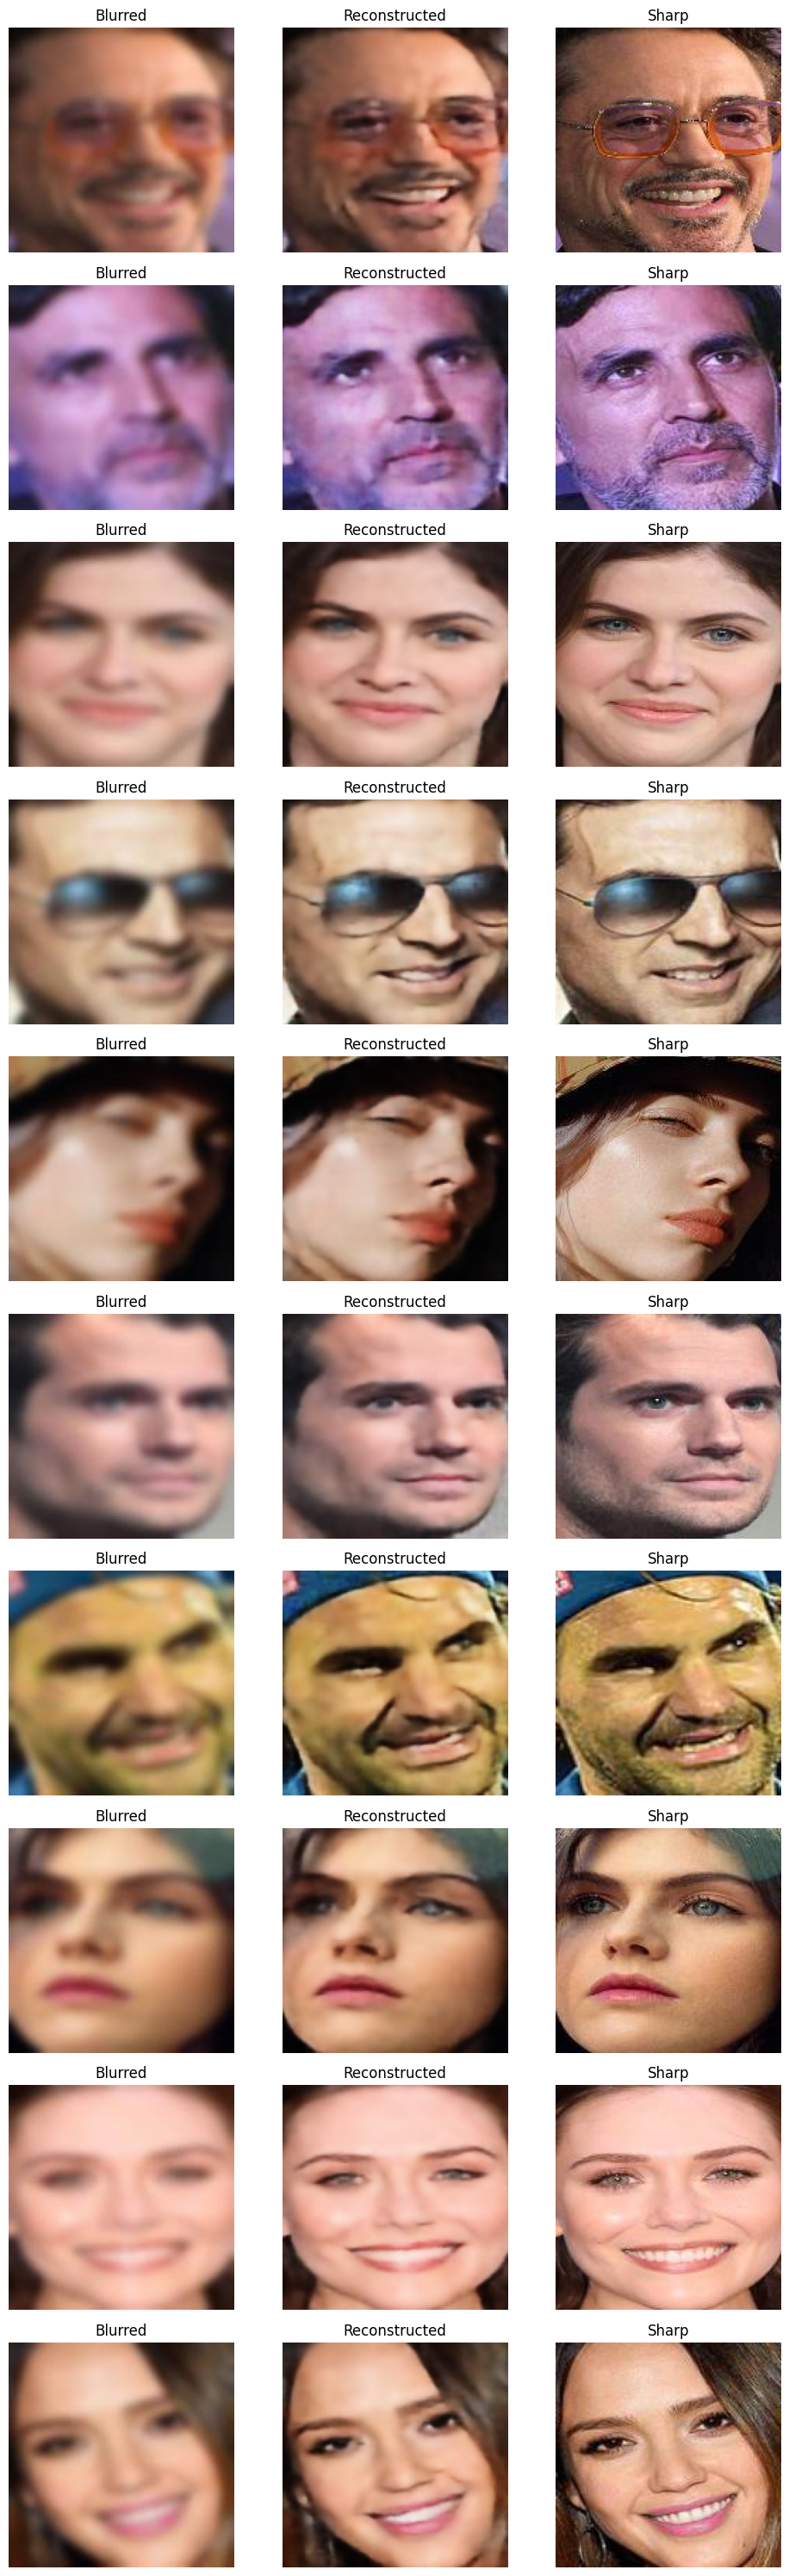

In [32]:
# Call the function to display the images
display_images(model, dataloader, num_images=10)

In [34]:
# Example function to save model weights after training
torch.save(model.state_dict(), 'deblur_autoencoder.pth')
# model.load_state_dict(torch.load('model_weights.pth'))

In [ ]:
# import cv2

# def resize_image_opencv(image_path, output_path):
#     image = cv2.imread(image_path)
#     resized_image = cv2.resize(image, (160, 160))  # Resize to 160x160
#     cv2.imwrite(output_path, resized_image)



In [ ]:
import os
import torch
import matplotlib.pyplot as plt

def save_reconstructed_images(model, dataloader, num_images, output_dir='final prod/sharp_final/blurred'):
    model.eval()  # Set the model to evaluation mode

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)  # Create the output directory if it doesn't exist

    with torch.no_grad():  # Disable gradient calculation for inference
        image_count = 0
        for i, (blurred_images, sharp_images) in enumerate(dataloader):
            if image_count >= num_images:
                break

            # Move images to GPU if available
            blurred_images = blurred_images.cuda()
            
            # Forward pass to get reconstructed (deblurred) images
            reconstructed_images = model(blurred_images)

            # Move images back to CPU and detach from computation graph
            reconstructed_images = reconstructed_images.cpu().numpy().transpose(0, 2, 3, 1)

            # Save images
            for j in range(len(reconstructed_images)):
                if image_count >= num_images:
                    break

                output_path = os.path.join(output_dir, f"reconstructed_{image_count+1}.png")
                
                plt.imsave(output_path, reconstructed_images[j])  # Save image
                image_count += 1

    print(f"Reconstructed images saved in '{output_dir}'.")

# Example usage
# save_reconstructed_images(model, dataloader, num_images=10)


In [36]:
import cv2
import os

def resize_images_opencv(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)  # Create output directory if not exists

    for filename in os.listdir(input_dir):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)

        # Read and resize the image
        image = cv2.imread(input_path)
        if image is None:
            continue  # Skip invalid images

        resized_image = cv2.resize(image, (160, 160))
        cv2.imwrite(output_path, resized_image)
    
    print(f"Resized images saved in {output_dir}")




In [37]:
# Example usage
resize_images_opencv("final prod/resize", "final prod/output")

Resized images saved in final prod/output


In [38]:
create_paired_dataset('final prod/output', 'final prod/sharp_final', kernel_size=(25, 25), sigma=3)

100%|██████████| 3/3 [00:00<00:00, 61.74it/s]


In [39]:
sharp_dir = 'final prod/sharp_final/sharp'  # Replace with the path to your sharp images
blurred_dir = 'final prod/sharp_final/blurred'  # Replace with the path to your blurred images
print("Creating Data")
dataset = DeblurDataset(sharp_dir, blurred_dir, transform=transform)
print("Loading Data")
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
print("Loading Model")

Creating Data
Loading Data
Loading Model


In [40]:
# dataset = DeblurDataset(sharp_dir='final prod/sharp_final/sharp', blurred_dir='final prod/sharp_final/blurred', transform=transform)
# dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
save_reconstructed_images(model, dataloader, output_dir='pred_output', num_images=3)

NameError: name 'save_reconstructed_images' is not defined

In [66]:
sharp_dir = 'final prod/sharp_final/sharp'  # Replace with the path to your sharp images
blurred_dir = 'final prod/sharp_final/sharp'  # Replace with the path to your blurred images
print("Creating Data")
dataset = DeblurDataset(sharp_dir, blurred_dir, transform=transform)
print("Loading Data")
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
print("Loading Model")

Creating Data
Loading Data
Loading Model
